<a href="https://colab.research.google.com/github/takumaosada/COVID-19-Basic-Analysis/blob/master/signate_phase1_covid19_case_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの確認/読み込み


## データの読み込み

In [200]:
!pip install japanize_matplotlib category_encoders xgboost optuna shap

In [201]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import japanize_matplotlib
import category_encoders as ce
import gspread
import re
import itertools
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve, BaseCrossValidator
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from oauth2client.client import GoogleCredentials
from google.colab import auth
import warnings
import xgboost as xgb
from IPython.display import clear_output
import optuna
import functools
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import shap
from pprint import pprint
from optuna.integration import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
shap.initjs()
auth.authenticate_user()

In [202]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [203]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1VLSA8q2zPCbaTDXXcMsxK0HRZlFRVH7_x0rLd4Z7Jk8/edit#gid=960903158'
book = gc.open_by_url(singatecasefilelink)
casedata = book.worksheet('罹患者').get_all_values()
casedf = pd.DataFrame(casedata)

In [204]:
#データフレームを整理していく
area_dict = dict(zip(casedf.index, casedf.iloc[0]))
renamed_df = casedf.rename(columns=area_dict)
df = renamed_df.drop(0)
df =df.drop_duplicates()
df.drop(df.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
16156,50,1,50-1,,,,中部国際空港,,,,,,,,,,,,,,,,,,0,0,,,
16157,51,27,51-27,,2020/03/27,,関西国際空港,不明,,20 - 29,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16158,51,28,51-28,,2020/03/27,,関西国際空港,兵庫県,,非公表,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16159,51,52,51-52,,2020/03/30,,関西国際空港,不明,,30 - 39,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29ドイツから帰国,0,0,,,
16160,51,53,51-53,,2020/03/30,,関西国際空港,不明,,40 - 49,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29オランダから帰国,0,0,,,


## データの確認

In [205]:
df.describe()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
count,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161
unique,51,5175,16158,218,176,178,51,73,791,12,6,121,8,6,6,5995,1812,2907,3984,226,9,4,3232,1336,2,2,1900,3286,229
top,13,1,21-150,非公表,,2020/04/11,東京都,東京都,,50 - 59,男性,,,,,,,,,,,,,,0,0,,,
freq,5162,47,2,5205,4784,674,5162,3836,4638,2636,8682,6541,9412,8836,11928,8179,10814,9974,8403,12728,10125,10885,4091,12960,11871,15934,12197,12198,13890


## データクリーニング


In [206]:
#性別でのデータクリーニングを行う
df = df[(df['性別'] == "男性") | (df['性別'] == '女性')]
#年代でのデータクリーニングを行う
df = df[(df['年代'] != "51 - 59") & (df['年代'] != '非公表') & (df['年代'] != '')]

In [207]:
#性別をencodeする
import category_encoders as ce
df_gender = df['性別']
list_cols = ['性別']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['性別'] = ce_ohe.fit_transform(df_gender)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [208]:
#年代をencodeする
df_age = df['年代']
list_cols = ['年代']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['年代'] = ce_ohe.fit_transform(df_age)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## 症状のデータの読み込み

In [209]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1OpNYBk8PHB3hskPHLkD4-I7oIWEGwfixhI9K2-hVZyY/edit#gid=1290212813'
symptom_book = gc.open_by_url(singatecasefilelink)
symptom_data = symptom_book.worksheet('症状').get_all_values()
symptomdf = pd.DataFrame(symptom_data)

In [210]:
area_dict = dict(zip(symptomdf.index, symptomdf.iloc[0]))
renamed_df = symptomdf.rename(columns=area_dict)
symptomdf = renamed_df.drop(0)
symptomdf =symptomdf.drop_duplicates()
symptomdf.drop(symptomdf.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
161779,13,40869,13-40869,非公表,-,-,-
161781,13,40870,13-40870,非公表,-,-,-
161783,13,40871,13-40871,非公表,-,-,-
161785,13,40872,13-40872,非公表,-,-,-
161787,13,40873,13-40873,非公表,-,-,-


In [211]:
symptomdf = symptomdf[(symptomdf['症状'] != "-")]

In [212]:
symptoms = symptomdf["症状"].unique()
symptoms_list = list()
for element in symptoms:
  elements = re.split('[;，]', element)
  symptoms_list.append(elements)

In [213]:
unique_symptons_list = list(itertools.chain.from_iterable(symptoms_list))
unique_symptons_list = list(set(unique_symptons_list))

In [214]:
#不要な要素を取り除く
# 検査しないとわからない項目は取り除く
# 今回は死亡、受診、入院、退院、肺炎を取り除く
# 追加で呼吸困難は影響が大きすぎるので排除する
cleaned_symptoms_list = list()
for element in unique_symptons_list:
  if not ("icd" in element or "受診" in element or "死亡" in element):
    if not ("入院" in element or "肺炎" in element or "退院" in element or "呼吸困難" in element):
        cleaned_symptoms_list.append(element)

In [215]:
cleaned_symptoms_list

['',
 '扁桃炎',
 '肩部痛',
 '乏尿',
 'ほてり',
 '下腹痛',
 '尿路感染症',
 '敗血症性ショック',
 'こむら返り',
 '胃痛',
 '胸部異常陰影',
 '歩行困難',
 '健康相談',
 '関節炎',
 '咳',
 '味覚異常',
 '咽頭異常感症',
 '意識障害',
 '嗄声',
 '胃腸疾患',
 '気管支炎',
 'ぶどう球菌感染症',
 '耳痛症',
 '眼痛',
 '脱力感',
 '喉頭炎',
 '喀痰',
 '関節痛',
 '口渇症',
 '麻疹',
 '腹部不快感',
 '咽頭炎',
 '胸内苦悶',
 '発熱',
 '頚部痛',
 '倦怠感',
 '膿性痰',
 '高血圧症',
 '不安障害',
 '貧血',
 'つかえ感',
 '鼻閉',
 '喘鳴',
 '急性上気道炎',
 '吐血',
 '疼痛',
 '紅斑症',
 '肝機能障害',
 '腹痛症',
 '窒息感',
 '耳鳴症',
 '老衰',
 '発音障害',
 'ピリピリ感',
 '前胸部痛',
 '喉頭痛',
 '結膜充血',
 '下肢しびれ',
 '敗血症',
 '後頭部痛',
 '過剰喀痰',
 '脱水症',
 '心肺停止',
 '眼精疲労',
 '悪心',
 '胸痛',
 '味覚減退症',
 '糖尿病',
 '急性鼻炎',
 '多尿',
 '味覚障害',
 '肩こり',
 '摂食障害',
 '頭重感',
 '聴覚異常',
 '神経痛',
 '胆石性急性胆のう炎',
 '心配',
 '鼻痛',
 '心不全',
 '下痢症',
 '鼻閉感',
 'ブラ',
 '血腫',
 '嗅覚障害',
 '摂食機能障害',
 '項部痛',
 '血痰',
 '血尿',
 '嗅覚異常',
 '胸水貯留',
 '鼻漏',
 'じんま疹',
 '結膜炎',
 '鼻炎',
 '感冒',
 'インフルエンザ',
 '腎不全',
 '肺野異常陰影',
 '乾性咳',
 '筋肉痛',
 '背部痛',
 '項部腫脹',
 '肋骨痛',
 '特発性拡張型心筋症',
 '末梢循環障害',
 '腰殿部痛',
 '顔面痛',
 'よう',
 'めまい',
 '外傷',
 'アレルギー',
 '食欲不振',
 '微熱',
 '全身倦怠感',
 '嘔気',
 '頭痛',
 'コロナウイルス

# 勾配ブースティング法を用いたモデルの作成


## データの整理

In [216]:
df_new = df[["都道府県コード", "年代", "性別", "ステータス", "症状一覧"]]

In [217]:
# ステータスは`非公開`や``をdropし、死亡を４、重症を3、中等症を２、軽症、無症状を1とする
df_new = df_new[(df['ステータス'] == "重症") | (df['ステータス'] == '軽症') | (df['ステータス'] == '死亡') | (df['ステータス'] == '無症状') | (df['ステータス'] == '中等症')]
df_new["ステータス"] = df_new["ステータス"].str.replace("重症", "1").str.replace("死亡", "1").str.replace("中等症", "0").str.replace("軽症", "0").str.replace("無症状", "0")
df_new["ステータス"] = df_new["ステータス"].astype(int)

In [218]:
for element in cleaned_symptoms_list:
  df_new[element] = df_new["症状一覧"].str.contains(element)

In [219]:
df_new["都道府県コード"] = df_new["都道府県コード"].astype(int)

In [220]:
# 症状一覧をdropする
df_new = df_new.drop('症状一覧', axis=1)

## XGBoostを用いるケース

In [221]:
params1 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}

params2 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'auc',
}

In [222]:
def plot_xgboost_result(df):
  # モデルの作成(xgboost)
  x_train, x_test, y_train, y_test = train_test_split(df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1), df['ステータス'], stratify=df['ステータス'], test_size=0.3, random_state=0)

  dtrain = xgb.DMatrix(x_train, label=y_train)
  dtest = xgb.DMatrix(x_test, label=y_test)

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  model1= xgb.train(
      params1,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  y_pred = model1.predict(dtest)
  y_true = y_test.values

  train_metric = evals_result['train']['mae']
  eval_metric = evals_result['test']['mae']
  fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(24,15))
  axes[0,0].plot(train_metric, label='train mae')
  axes[0,0].plot(eval_metric, label='test mae', linestyle='dashed')
  axes[0,0].grid()
  axes[0,0].legend()
  axes[0,0].set_xlabel('学習回数')
  axes[0,0].set_ylabel('平均絶対誤差')

  xgb.plot_importance(model1, ax=axes[0,1], importance_type='gain', title='項目の重要度', show_values=False)
  axes[0,1].set_ylabel("項目")

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  # モデルの作成(AUC)
  model2 = xgb.train(
      params2,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  check = model2.predict(dtest)
  fpr, tpr, thresholds = roc_curve(y_true, check)
  axes[1,0].plot(fpr, tpr, marker='o')
  axes[1,0].set_xlabel('FPR: False positive rate')
  axes[1,0].set_ylabel('TPR: True positive rate')
  axes[1,0].grid()

  history = xgb.cv(params1, dtrain, num_boost_round=200, early_stopping_rounds=10, nfold=10, verbose_eval=False, stratified=True)
  train_metric = history['train-mae-mean']
  eval_metric = history['test-mae-mean']
  axes[1,1].plot(train_metric, label='train mae')
  axes[1,1].plot(eval_metric, label='eval mae', linestyle='dashed')
  axes[1,1].grid()
  axes[1,1].legend()
  axes[1,1].set_xlabel('round')
  axes[1,1].set_ylabel('mae')
  print("重症,死亡の患者の数", df['ステータス'].value_counts()[1], '-', df['ステータス'].value_counts()[0])
  print("AUCのベストスコア", model2.best_score)

In [251]:
def xgboost_sharp(df):
  x_train, x_test, y_train, y_test = train_test_split(df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1), df['ステータス'], stratify=df['ステータス'], test_size=0.1, random_state=0)
  params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }

  model = xgb.XGBClassifier(**params)
  model.fit(x_train, y_train)

  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(x_train)
  shap.summary_plot(shap_values, x_train)

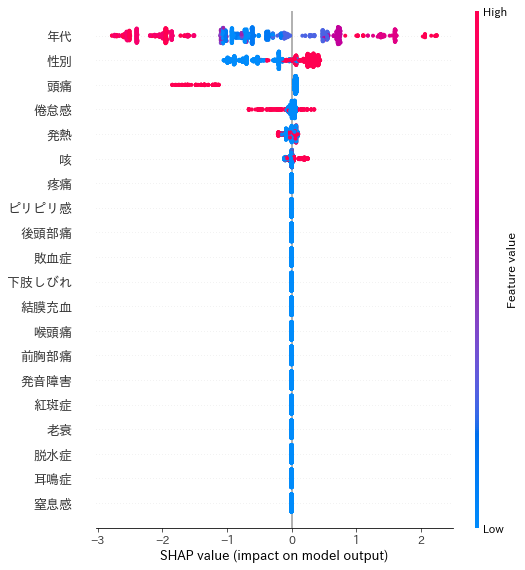

In [255]:
df_new_kanto = df_new[(df_new["都道府県コード"] == 8) | (df_new["都道府県コード"] == 9) | (df_new["都道府県コード"] == 10) | (df_new["都道府県コード"] == 11) | (df_new["都道府県コード"] == 12) | (df_new["都道府県コード"] == 13) | (df_new["都道府県コード"] == 14)]
xgboost_sharp(df_new_kanto)

In [225]:
def cross_validation(df, random_state = 0):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=random_state)
  model = LogisticRegression().fit(x_train, y_train)
  kf_with_shuffle = KFold(n_splits = 10, shuffle = True, random_state = random_state)
  kf_without_shuffle = KFold(n_splits = 10, shuffle = False, random_state = random_state)
  strat_kf_with_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state= random_state)
  strat_kf_withøut_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state= random_state)
  test_data_score = model.score(x_test, y_test)
  kfold_scores_with_shuffle = cross_val_score(model, x, y, cv=kf_with_shuffle)
  kfold_scores_without_shuffle = cross_val_score(model, x, y, cv=kf_without_shuffle)
  strat_kfold_score_with_shuffle = cross_val_score(model, x, y, cv=strat_kf_with_shuffle)
  strat_kfold_score_without_shuffle = cross_val_score(model, x, y, cv=strat_kf_withøut_shuffle)
  print("random_stateの値", random_state)
  print("テストデータのスコア", test_data_score)
  print("交差検証のスコア平均(シャッフルあり)", kfold_scores_with_shuffle.mean())
  print("交差検証のスコア平均(シャッフルなし)", kfold_scores_without_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルあり)", strat_kfold_score_with_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルなし)", strat_kfold_score_without_shuffle.mean())

In [226]:
# 重症患者の割合が少ないことから予測値が全て軽傷患者である判定をしてしまっている
# そのため不均衡データ分析を行う必要がある
# 今回はオーバーサンプリングとアンダーサンプリングの２種類を用いて不均衡なデータでも十分な分析ができるようにする

## LightGBMを用いるケース

In [227]:
# サンプリングレートを元に確率を補正する
def probability_calibration(y_proba, beta):
    calibrated_proba = y_proba / (y_proba + (1 - y_proba) / beta)
    return calibrated_proba

In [228]:
def calcurate_precision(test_data, data, percentage):
  p_1 = np.array(data)[test_data == 1]
  cal_percentage = 1 - percentage
  p_1_q = np.quantile(p_1,cal_percentage)
  y_q = test_data[np.array(data)>p_1_q]
  if sum(y_q) != 0:
    print('recallが', percentage, 'の割合で指定された時のprecision', sum(y_q)/len(y_q))

In [229]:
def check_classification(df):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  # まずは不均衡データのままロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train, y_train)
  # 検証用データを予測させる
  y_pred_proba_base = clf.predict_proba(X_test)[:, 1]
  y_pred_base = np.where(y_pred_proba_base > 0.163, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_base, percentage)

  # Under-sampling で均衡データにする
  sampler = RandomUnderSampler(random_state=42)
  X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

  # Over-sampling で均衡データにする
  over_sampler = SMOTE(random_state=42)
  X_train_over_sampled, y_train_over_sampled = over_sampler.fit_sample(X_train, y_train)

  # Under-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_sampled, y_train_sampled)
  # Under-samplingの検証用データを予測させる
  y_pred_proba_us = clf.predict_proba(X_test)[:, 1]
  y_pred_us = np.where(y_pred_proba_us > 0.163, 1, 0)


  # Over-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_over_sampled, y_train_over_sampled)
  # Over-samplingの検証用データを予測させる
  y_pred_proba_os = clf.predict_proba(X_test)[:, 1]
  y_pred_os = np.where(y_pred_proba_os > 0.163, 1, 0)

  # サンプリングレートを元に確率を補正する
  y_train_zero_len = np.count_nonzero(y_train_sampled == 0)
  beta = y_train_zero_len / len(y_train)
  y_pred_proba_cb = probability_calibration(y_pred_proba_us, beta)
  y_pred_cb = np.where(y_pred_proba_cb > 0.163, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_cb, percentage)

  # 各種評価指標を出力する
  # 精度
  print('precision (base): ', metrics.precision_score(y_test, y_pred_base))
  print('precision (under-sampling): ', metrics.precision_score(y_test, y_pred_us))
  print('precision (over-sampling): ', metrics.precision_score(y_test, y_pred_os))
  print('precision (calibrated): ', metrics.precision_score(y_test, y_pred_cb))
  # 検出率
  print('recall (base): ', metrics.recall_score(y_test, y_pred_base))
  print('recall (under-sampling): ', metrics.recall_score(y_test, y_pred_us))
  print('recall (over-sampling): ', metrics.recall_score(y_test, y_pred_os))
  print('recall (calibrated): ', metrics.recall_score(y_test, y_pred_cb))
  # F値
  print('F1 (base): ', metrics.f1_score(y_test, y_pred_base))
  print('F1 (under-sampling): ', metrics.f1_score(y_test, y_pred_us))
  print('F1 (over-sampling): ', metrics.f1_score(y_test, y_pred_os))
  print('F1 (calibrated): ', metrics.f1_score(y_test, y_pred_cb))
  # ROC
  print('ROC AUC (base): ', metrics.roc_auc_score(y_test, y_pred_base))
  print('ROC AUC (under-sampling): ', metrics.roc_auc_score(y_test, y_pred_us))
  print('ROC AUC (over-sampling): ', metrics.roc_auc_score(y_test, y_pred_os))
  print('ROC AUC (calibrated): ', metrics.roc_auc_score(y_test, y_pred_cb))

  # 各モデルが予測した内容の統計量
  print('y_test mean', y_test.mean())
  print('y_proba mean (base)', y_pred_proba_base.mean())
  print('y_proba mean (under-sampling)', y_pred_proba_us.mean())
  print('y_proba mean (over-sampling)', y_pred_proba_os.mean())
  print('y_proba mean (calibrated)', y_pred_proba_cb.mean())

  # キャリブレーションカーブを計算する
  base_curve = calibration_curve(y_test, y_pred_proba_base, n_bins=10)
  undersampling_curve = calibration_curve(y_test, y_pred_proba_us, n_bins=10)
  oversampling_curve = calibration_curve(y_test, y_pred_proba_os, n_bins=10)
  calibrated_curve = calibration_curve(y_test, y_pred_proba_cb, n_bins=10)

  # プロットする
  fig, axes = plt.subplots(2, 1, figsize=(8, 7))

  ax1 = axes[0]
  ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
  ax1.plot(base_curve[0], base_curve[1], label='base')
  ax1.plot(undersampling_curve[0], undersampling_curve[1], label='under-sampling')
  ax1.plot(oversampling_curve[0], oversampling_curve[1], label='over-sampling')
  ax1.plot(calibrated_curve[0], calibrated_curve[1], label='calibrated')

  ax1.grid()
  ax1.set_ylabel('Fraction of positives')
  ax1.set_xlabel('Prediction probability')
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc='lower right')

  ax2 = axes[1]
  ax2.hist(y_pred_proba_base, bins=144, alpha=0.5, color='red', label='y_pred_proba (base)')
  ax2.hist(y_pred_proba_us, bins=144, alpha=0.5, color='orange', label='y_pred_proba (under-sampling)')
  ax2.hist(y_pred_proba_os, bins=144, alpha=0.5, color='blue', label='y_pred_proba (over-sampling)')
  ax2.hist(y_pred_proba_cb, bins=144, alpha=0.5, color='green', label='y_pred_proba (calibrated)')
  ax2.axvline(x=y_test.mean(), color='blue', label='y_test mean')
  ax2.axvline(x=y_pred_proba_base.mean(), color='red', label='y_proba mean (base)')
  ax2.axvline(x=y_pred_proba_us.mean(), color='orange', label='y_proba mean (under-sampling)')
  ax2.axvline(x=y_pred_proba_os.mean(), color='blue', label='y_proba mean (over-sampling)')
  ax2.axvline(x=y_pred_proba_cb.mean(), color='green', label='y_proba mean (calibrated)')

  ax2.set_xlabel('Prediction Probability')
  ax2.set_ylabel('Frequency')

  plt.legend()
  plt.show()

recallが 0.2 の割合で指定された時のprecision 0.05759162303664921
recallが 0.3 の割合で指定された時のprecision 0.08928571428571429
recallが 0.4 の割合で指定された時のprecision 0.0975609756097561
recallが 0.5 の割合で指定された時のprecision 0.10179640718562874
recallが 0.6 の割合で指定された時のprecision 0.09069767441860466
recallが 0.7 の割合で指定された時のprecision 0.08333333333333333
recallが 0.8 の割合で指定された時のprecision 0.07528409090909091
recallが 0.9 の割合で指定された時のprecision 0.07711442786069651


Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Precision is

recallが 0.1 の割合で指定された時のprecision 0.06358381502890173
recallが 0.2 の割合で指定された時のprecision 0.06043956043956044
recallが 0.3 の割合で指定された時のprecision 0.08333333333333333
recallが 0.4 の割合で指定された時のprecision 0.09352517985611511
recallが 0.5 の割合で指定された時のprecision 0.09696969696969697
recallが 0.6 の割合で指定された時のprecision 0.0891304347826087
recallが 0.7 の割合で指定された時のprecision 0.08348134991119005
recallが 0.8 の割合で指定された時のprecision 0.07417974322396577
recallが 0.9 の割合で指定された時のprecision 0.07011494252873564
precision (base):  0.0
precision (under-sampling):  0.06133333333333333
precision (over-sampling):  0.06500956022944551
precision (calibrated):  0.0
recall (base):  0.0
recall (under-sampling):  1.0
recall (over-sampling):  0.9855072463768116
recall (calibrated):  0.0
F1 (base):  0.0
F1 (under-sampling):  0.11557788944723618
F1 (over-sampling):  0.12197309417040358
F1 (calibrated):  0.0
ROC AUC (base):  0.5
ROC AUC (under-sampling):  0.5142594296228151
ROC AUC (over-sampling):  0.5428916176686266
ROC AUC (calibrated): 

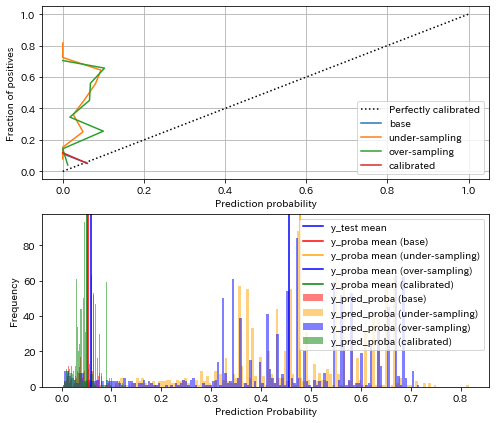

In [230]:
check_classification(df_new)

[I 2020-12-15 19:14:32,021] A new study created in memory with name: no-name-1abc267b-1b4f-4f31-bce7-cf82399f189b
feature_fraction, val_score: 0.166664:  14%|#4        | 1/7 [00:00<00:00,  6.51it/s]

重傷者の数の出力 0    5465
1     312
Name: ステータス, dtype: int64
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.202891
[20]	valid_0's binary_logloss: 0.197768
[30]	valid_0's binary_logloss: 0.193655
[40]	valid_0's binary_logloss: 0.189628
[50]	valid_0's binary_logloss: 0.18617
[60]	valid_0's binary_logloss: 0.184091
[70]	valid_0's binary_logloss: 0.1823
[80]	valid_0's binary_logloss: 0.180496
[90]	valid_0's binary_logloss: 0.178916
[100]	valid_0's binary_logloss: 0.176858
[110]	valid_0's binary_logloss: 0.175594
[120]	valid_0's binary_logloss: 0.173661
[130]	valid_0's binary_logloss: 0.172028
[140]	valid_0's binary_logloss: 0.170674
[150]	valid_0's binary_logloss: 0.170112
[160]	valid_0's binary_logloss: 0.169814
[170]	valid_0's binary_logloss: 0.169934
[180]	valid_0's binary_logloss: 0.169057
[190]	valid_0's binary_logloss: 0.168564
[200]	valid_0's binary_logloss: 0.167702
[210]	valid_0's binary_logloss: 0.167252
[220]	valid_0's binary_logloss: 0.

feature_fraction, val_score: 0.166664:  29%|##8       | 2/7 [00:00<00:00,  6.77it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.20329
[20]	valid_0's binary_logloss: 0.197416
[30]	valid_0's binary_logloss: 0.192875
[40]	valid_0's binary_logloss: 0.188674
[50]	valid_0's binary_logloss: 0.185522
[60]	valid_0's binary_logloss: 0.182947
[70]	valid_0's binary_logloss: 0.181239
[80]	valid_0's binary_logloss: 0.179041
[90]	valid_0's binary_logloss: 0.177844
[100]	valid_0's binary_logloss: 0.176229
[110]	valid_0's binary_logloss: 0.175037
[120]	valid_0's binary_logloss: 0.172963
[130]	valid_0's binary_logloss: 0.171625
[140]	valid_0's binary_logloss: 0.170552
[150]	valid_0's binary_logloss: 0.169584
[160]	valid_0's binary_logloss: 0.169246
[170]	valid_0's binary_logloss: 0.169393
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.169069
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.203466
[20]	valid_0's binary_logloss: 0.197643
[30]	valid_0's binary_logloss: 0.

feature_fraction, val_score: 0.165812:  57%|#####7    | 4/7 [00:00<00:00,  6.57it/s]

[190]	valid_0's binary_logloss: 0.16707
[200]	valid_0's binary_logloss: 0.166502
[210]	valid_0's binary_logloss: 0.166403
[220]	valid_0's binary_logloss: 0.165812
[230]	valid_0's binary_logloss: 0.166045
Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.165812
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.203318
[20]	valid_0's binary_logloss: 0.198222
[30]	valid_0's binary_logloss: 0.193524
[40]	valid_0's binary_logloss: 0.18934
[50]	valid_0's binary_logloss: 0.186476
[60]	valid_0's binary_logloss: 0.184231
[70]	valid_0's binary_logloss: 0.18231
[80]	valid_0's binary_logloss: 0.180374
[90]	valid_0's binary_logloss: 0.179133
[100]	valid_0's binary_logloss: 0.177164
[110]	valid_0's binary_logloss: 0.17579
[120]	valid_0's binary_logloss: 0.174016
[130]	valid_0's binary_logloss: 0.172305
[140]	valid_0's binary_logloss: 0.171308
[150]	valid_0's binary_logloss: 0.170689
[160]	valid_0's binary_logloss: 0.170029
[170]	valid_0'

feature_fraction, val_score: 0.165812:  71%|#######1  | 5/7 [00:00<00:00,  6.54it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.204831
[20]	valid_0's binary_logloss: 0.199933
[30]	valid_0's binary_logloss: 0.194703
[40]	valid_0's binary_logloss: 0.190954
[50]	valid_0's binary_logloss: 0.188655
[60]	valid_0's binary_logloss: 0.186729
[70]	valid_0's binary_logloss: 0.184578
[80]	valid_0's binary_logloss: 0.182101
[90]	valid_0's binary_logloss: 0.18066
[100]	valid_0's binary_logloss: 0.178703
[110]	valid_0's binary_logloss: 0.176896
[120]	valid_0's binary_logloss: 0.175802
[130]	valid_0's binary_logloss: 0.173973
[140]	valid_0's binary_logloss: 0.172664
[150]	valid_0's binary_logloss: 0.171867
[160]	valid_0's binary_logloss: 0.171105
[170]	valid_0's binary_logloss: 0.171206
[180]	valid_0's binary_logloss: 0.169922
[190]	valid_0's binary_logloss: 0.169445
[200]	valid_0's binary_logloss: 0.168514
[210]	valid_0's binary_logloss: 0.168205
[220]	valid_0's binary_logloss: 0.167493
[230]	valid_0's binary_logloss: 0.167285
Early

feature_fraction, val_score: 0.165812:  86%|########5 | 6/7 [00:00<00:00,  6.57it/s]

[140]	valid_0's binary_logloss: 0.176166
[150]	valid_0's binary_logloss: 0.175179
[160]	valid_0's binary_logloss: 0.174699
[170]	valid_0's binary_logloss: 0.174556
[180]	valid_0's binary_logloss: 0.173098
[190]	valid_0's binary_logloss: 0.17218
[200]	valid_0's binary_logloss: 0.172001
[210]	valid_0's binary_logloss: 0.171204
[220]	valid_0's binary_logloss: 0.171353
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.171029
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.202765
[20]	valid_0's binary_logloss: 0.1973
[30]	valid_0's binary_logloss: 0.191694
[40]	valid_0's binary_logloss: 0.18773
[50]	valid_0's binary_logloss: 0.184625
[60]	valid_0's binary_logloss: 0.182815
[70]	valid_0's binary_logloss: 0.180866
[80]	valid_0's binary_logloss: 0.178892
[90]	valid_0's binary_logloss: 0.176345
[100]	valid_0's binary_logloss: 0.174364
[110]	valid_0's binary_logloss: 0.173626
[120]	valid_0's binary_logloss: 0.171478
[130]	valid_0'

num_leaves, val_score: 0.163048:   5%|5         | 1/20 [00:00<00:02,  6.35it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167557


num_leaves, val_score: 0.163048:  15%|#5        | 3/20 [00:00<00:02,  6.88it/s]

[50]	valid_0's binary_logloss: 0.166439
[60]	valid_0's binary_logloss: 0.165406
[70]	valid_0's binary_logloss: 0.165033
[80]	valid_0's binary_logloss: 0.164459
[90]	valid_0's binary_logloss: 0.163499
[100]	valid_0's binary_logloss: 0.163364
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163079
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.180987
[20]	valid_0's binary_logloss: 0.173836
[30]	valid_0's binary_logloss: 0.170319
[40]	valid_0's binary_logloss: 0.167829
[50]	valid_0's binary_logloss: 0.166662
[60]	valid_0's binary_logloss: 0.166093
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.166019


num_leaves, val_score: 0.163048:  20%|##        | 4/20 [00:00<00:02,  6.54it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454


num_leaves, val_score: 0.163048:  25%|##5       | 5/20 [00:00<00:02,  6.15it/s]

[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444


num_leaves, val_score: 0.163048:  30%|###       | 6/20 [00:00<00:02,  6.09it/s]

[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619


num_leaves, val_score: 0.163048:  40%|####      | 8/20 [00:01<00:01,  6.02it/s]

[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048


num_leaves, val_score: 0.163048:  45%|####5     | 9/20 [00:01<00:01,  6.08it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444


num_leaves, val_score: 0.163048:  50%|#####     | 10/20 [00:01<00:01,  6.07it/s]

[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619


num_leaves, val_score: 0.163048:  60%|######    | 12/20 [00:01<00:01,  6.05it/s]

[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048


num_leaves, val_score: 0.163048:  65%|######5   | 13/20 [00:02<00:01,  6.01it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444


num_leaves, val_score: 0.163048:  70%|#######   | 14/20 [00:02<00:00,  6.05it/s]

[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313


num_leaves, val_score: 0.163048:  80%|########  | 16/20 [00:02<00:00,  6.00it/s]

Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048


num_leaves, val_score: 0.163048:  85%|########5 | 17/20 [00:02<00:00,  5.97it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572


num_leaves, val_score: 0.163048:  90%|######### | 18/20 [00:02<00:00,  5.99it/s]

[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467


num_leaves, val_score: 0.163048: 100%|##########| 20/20 [00:03<00:00,  6.06it/s]

[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.181789
[20]	valid_0's binary_logloss: 0.174208
[30]	valid_0's binary_logloss: 0.170454
[40]	valid_0's binary_logloss: 0.167572
[50]	valid_0's binary_logloss: 0.166444
[60]	valid_0's binary_logloss: 0.165382
[70]	valid_0's binary_logloss: 0.16505
[80]	valid_0's binary_logloss: 0.164467
[90]	valid_0's binary_logloss: 0.163619
[100]	valid_0's binary_logloss: 0.163313
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.163048



bagging, val_score: 0.163048:  10%|#         | 1/10 [00:00<00:01,  7.70it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.176059
[20]	valid_0's binary_logloss: 0.169181
[30]	valid_0's binary_logloss: 0.166475
[40]	valid_0's binary_logloss: 0.165059
[50]	valid_0's binary_logloss: 0.165791
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.164739
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.183756
[20]	valid_0's binary_logloss: 0.176471
[30]	valid_0's binary_logloss: 0.171722
[40]	valid_0's binary_logloss: 0.17001
[50]	valid_0's binary_logloss: 0.169643
[60]	valid_0's binary_logloss: 0.169594
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.169131


bagging, val_score: 0.163048:  30%|###       | 3/10 [00:00<00:00,  7.75it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.185632
[20]	valid_0's binary_logloss: 0.180001
[30]	valid_0's binary_logloss: 0.173861
[40]	valid_0's binary_logloss: 0.172113
[50]	valid_0's binary_logloss: 0.170957
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.170855
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.178783
[20]	valid_0's binary_logloss: 0.169587
[30]	valid_0's binary_logloss: 0.167332
[40]	valid_0's binary_logloss: 0.165408
[50]	valid_0's binary_logloss: 0.164798
[60]	valid_0's binary_logloss: 0.16464
[70]	valid_0's binary_logloss: 0.163607


bagging, val_score: 0.161888:  50%|#####     | 5/10 [00:00<00:00,  7.23it/s]

[80]	valid_0's binary_logloss: 0.162357
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.161888
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.17885
[20]	valid_0's binary_logloss: 0.169467
[30]	valid_0's binary_logloss: 0.16737
[40]	valid_0's binary_logloss: 0.165257
[50]	valid_0's binary_logloss: 0.164663
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.164124


bagging, val_score: 0.161487:  60%|######    | 6/10 [00:00<00:00,  6.72it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.180143
[20]	valid_0's binary_logloss: 0.172832
[30]	valid_0's binary_logloss: 0.168734
[40]	valid_0's binary_logloss: 0.16623
[50]	valid_0's binary_logloss: 0.165646
[60]	valid_0's binary_logloss: 0.163935
[70]	valid_0's binary_logloss: 0.162379
[80]	valid_0's binary_logloss: 0.161487
[90]	valid_0's binary_logloss: 0.163306
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161487
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.17998
[20]	valid_0's binary_logloss: 0.1732
[30]	valid_0's binary_logloss: 0.1685
[40]	valid_0's binary_logloss: 0.165518


bagging, val_score: 0.161487:  80%|########  | 8/10 [00:01<00:00,  7.45it/s]

[50]	valid_0's binary_logloss: 0.165971
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.165506
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.179286
[20]	valid_0's binary_logloss: 0.169761
[30]	valid_0's binary_logloss: 0.165793
[40]	valid_0's binary_logloss: 0.16368
[50]	valid_0's binary_logloss: 0.165153
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.163257
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.161487:  90%|######### | 9/10 [00:01<00:00,  6.66it/s]

[10]	valid_0's binary_logloss: 0.178786
[20]	valid_0's binary_logloss: 0.171508
[30]	valid_0's binary_logloss: 0.168523
[40]	valid_0's binary_logloss: 0.165822
[50]	valid_0's binary_logloss: 0.165077
[60]	valid_0's binary_logloss: 0.164441
[70]	valid_0's binary_logloss: 0.16375
[80]	valid_0's binary_logloss: 0.162959
[90]	valid_0's binary_logloss: 0.163786
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.162959
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.178708
[20]	valid_0's binary_logloss: 0.171863


feature_fraction_stage2, val_score: 0.161487:   0%|          | 0/3 [00:00<?, ?it/s]

[30]	valid_0's binary_logloss: 0.168159
[40]	valid_0's binary_logloss: 0.166207
[50]	valid_0's binary_logloss: 0.166252
[60]	valid_0's binary_logloss: 0.165609
[70]	valid_0's binary_logloss: 0.164871
[80]	valid_0's binary_logloss: 0.164494
[90]	valid_0's binary_logloss: 0.165159
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.164494
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.179848
[20]	valid_0's binary_logloss: 0.173064
[30]	valid_0's binary_logloss: 0.169045
[40]	valid_0's binary_logloss: 0.165841
[50]	valid_0's binary_logloss: 0.164982
[60]	valid_0's binary_logloss: 0.164002

feature_fraction_stage2, val_score: 0.161487:  33%|###3      | 1/3 [00:00<00:00,  6.11it/s]


[70]	valid_0's binary_logloss: 0.162891
[80]	valid_0's binary_logloss: 0.161797
[90]	valid_0's binary_logloss: 0.162128
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161797
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.179848
[20]	valid_0's binary_logloss: 0.173064
[30]	valid_0's binary_logloss: 0.169045
[40]	valid_0's binary_logloss: 0.165841
[50]	valid_0's binary_logloss: 0.164982
[60]	valid_0's binary_logloss: 0.164002
[70]	valid_0's binary_logloss: 0.162891
[80]	valid_0's binary_logloss: 0.161797
[90]	valid_0's binary_logloss: 0.162128
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161797


regularization_factors, val_score: 0.161238:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.182202
[20]	valid_0's binary_logloss: 0.17423
[30]	valid_0's binary_logloss: 0.168782
[40]	valid_0's binary_logloss: 0.165689
[50]	valid_0's binary_logloss: 0.165047
[60]	valid_0's binary_logloss: 0.163257
[70]	valid_0's binary_logloss: 0.162258
[80]	valid_0's binary_logloss: 0.161238
[90]	valid_0's binary_logloss: 0.161584
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161238
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175893
[20]	valid_0's binary_logloss: 0.167895


regularization_factors, val_score: 0.161238:  10%|#         | 2/20 [00:00<00:02,  7.75it/s]

[30]	valid_0's binary_logloss: 0.16466
[40]	valid_0's binary_logloss: 0.167269
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163741
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.189552
[20]	valid_0's binary_logloss: 0.183317
[30]	valid_0's binary_logloss: 0.179335
[40]	valid_0's binary_logloss: 0.176769
[50]	valid_0's binary_logloss: 0.174975
[60]	valid_0's binary_logloss: 0.174681
[70]	valid_0's binary_logloss: 0.174391
[80]	valid_0's binary_logloss: 0.173399
[90]	valid_0's binary_logloss: 0.173365
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.173365


regularization_factors, val_score: 0.161238:  15%|#5        | 3/20 [00:00<00:02,  7.42it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.188447
[20]	valid_0's binary_logloss: 0.180701
[30]	valid_0's binary_logloss: 0.176541
[40]	valid_0's binary_logloss: 0.173876
[50]	valid_0's binary_logloss: 0.171468
[60]	valid_0's binary_logloss: 0.17099
[70]	valid_0's binary_logloss: 0.170675
[80]	valid_0's binary_logloss: 0.169952
[90]	valid_0's binary_logloss: 0.16981
[100]	valid_0's binary_logloss: 0.169703
[110]	valid_0's binary_logloss: 0.169824
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.169703
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175859
[20]	valid_0's binary_logloss: 0.167972
[30]	valid_0's binary_logloss: 0.164455
[40]	valid_0's binary_logloss: 0.166021
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163696


regularization_factors, val_score: 0.161238:  30%|###       | 6/20 [00:00<00:01,  7.67it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175664
[20]	valid_0's binary_logloss: 0.167922
[30]	valid_0's binary_logloss: 0.164581
[40]	valid_0's binary_logloss: 0.165989
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163802
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175834
[20]	valid_0's binary_logloss: 0.16801
[30]	valid_0's binary_logloss: 0.164865
[40]	valid_0's binary_logloss: 0.166095
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.164161


regularization_factors, val_score: 0.161238:  40%|####      | 8/20 [00:01<00:01,  7.78it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175816
[20]	valid_0's binary_logloss: 0.168057
[30]	valid_0's binary_logloss: 0.164409
[40]	valid_0's binary_logloss: 0.165884
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.16355
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175892
[20]	valid_0's binary_logloss: 0.167808
[30]	valid_0's binary_logloss: 0.164384
[40]	valid_0's binary_logloss: 0.165784
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163586


regularization_factors, val_score: 0.161238:  50%|#####     | 10/20 [00:01<00:01,  7.66it/s][I 2020-12-15 19:14:39,694] Trial 49 finished with value: 0.16359081916255594 and parameters: {'lambda_l1': 6.183287840697266e-07, 'lambda_l2': 4.176842807807796e-05}. Best is trial 48 with value: 0.16286379508553686.


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175614
[20]	valid_0's binary_logloss: 0.166616
[30]	valid_0's binary_logloss: 0.163924
[40]	valid_0's binary_logloss: 0.162864
[50]	valid_0's binary_logloss: 0.166528
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.162864
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.17589
[20]	valid_0's binary_logloss: 0.16781
[30]	valid_0's binary_logloss: 0.164388
[40]	valid_0's binary_logloss: 0.165755
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163591


regularization_factors, val_score: 0.161238:  60%|######    | 12/20 [00:01<00:01,  7.92it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175362
[20]	valid_0's binary_logloss: 0.166278
[30]	valid_0's binary_logloss: 0.163795
[40]	valid_0's binary_logloss: 0.162879
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.162104
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175448
[20]	valid_0's binary_logloss: 0.166231
[30]	valid_0's binary_logloss: 0.163428
[40]	valid_0's binary_logloss: 0.162332
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.162283


regularization_factors, val_score: 0.161238:  65%|######5   | 13/20 [00:01<00:00,  7.84it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175405
[20]	valid_0's binary_logloss: 0.166573
[30]	valid_0's binary_logloss: 0.164432
[40]	valid_0's binary_logloss: 0.163816
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163454
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.182841
[20]	valid_0's binary_logloss: 0.175501
[30]	valid_0's binary_logloss: 0.170356
[40]	valid_0's binary_logloss: 0.167237
[50]	valid_0's binary_logloss: 0.165862
[60]	valid_0's binary_logloss: 0.164787
[70]	valid_0's binary_logloss: 0.164124
[80]	valid_0's binary_logloss: 0.162441


regularization_factors, val_score: 0.161238:  75%|#######5  | 15/20 [00:01<00:00,  7.44it/s]

[90]	valid_0's binary_logloss: 0.163089
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.162373
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175059
[20]	valid_0's binary_logloss: 0.16665
[30]	valid_0's binary_logloss: 0.16481
[40]	valid_0's binary_logloss: 0.165743
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.163435


regularization_factors, val_score: 0.161238:  85%|########5 | 17/20 [00:02<00:00,  7.63it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175709
[20]	valid_0's binary_logloss: 0.167299
[30]	valid_0's binary_logloss: 0.163816
[40]	valid_0's binary_logloss: 0.166677
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.176583
[20]	valid_0's binary_logloss: 0.16839
[30]	valid_0's binary_logloss: 0.164629
[40]	valid_0's binary_logloss: 0.162681
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.162648


regularization_factors, val_score: 0.161238:  95%|#########5| 19/20 [00:02<00:00,  7.52it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.179552
[20]	valid_0's binary_logloss: 0.172543
[30]	valid_0's binary_logloss: 0.168626
[40]	valid_0's binary_logloss: 0.166375
[50]	valid_0's binary_logloss: 0.165172
[60]	valid_0's binary_logloss: 0.16414
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.163755
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.17573
[20]	valid_0's binary_logloss: 0.167451
[30]	valid_0's binary_logloss: 0.164721
[40]	valid_0's binary_logloss: 0.164926
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.162967


[I 2020-12-15 19:14:40,883] Trial 58 finished with value: 0.16296704223962769 and parameters: {'lambda_l1': 0.012444630711224754, 'lambda_l2': 2.2864965875637314e-05}. Best is trial 50 with value: 0.16210354996552565.
min_data_in_leaf, val_score: 0.161238:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.175893
[20]	valid_0's binary_logloss: 0.16781
[30]	valid_0's binary_logloss: 0.164386
[40]	valid_0's binary_logloss: 0.165784
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.163586
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.182202
[20]	valid_0's binary_logloss: 0.17423
[30]	valid_0's binary_logloss: 0.168782
[40]	valid_0's binary_logloss: 0.165689
[50]	valid_0's binary_logloss: 0.165047
[60]	valid_0's binary_logloss: 0.163257


min_data_in_leaf, val_score: 0.161238:  40%|####      | 2/5 [00:00<00:00,  6.03it/s]

[70]	valid_0's binary_logloss: 0.162258
[80]	valid_0's binary_logloss: 0.161238
[90]	valid_0's binary_logloss: 0.161584
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161238
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.182202
[20]	valid_0's binary_logloss: 0.17423
[30]	valid_0's binary_logloss: 0.168782
[40]	valid_0's binary_logloss: 0.165689
[50]	valid_0's binary_logloss: 0.165047
[60]	valid_0's binary_logloss: 0.163257
[70]	valid_0's binary_logloss: 0.162258
[80]	valid_0's binary_logloss: 0.161238
[90]	valid_0's binary_logloss: 0.161584
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161238


min_data_in_leaf, val_score: 0.161238:  60%|######    | 3/5 [00:00<00:00,  6.05it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.182202
[20]	valid_0's binary_logloss: 0.17423
[30]	valid_0's binary_logloss: 0.168782
[40]	valid_0's binary_logloss: 0.165689
[50]	valid_0's binary_logloss: 0.165047
[60]	valid_0's binary_logloss: 0.163257
[70]	valid_0's binary_logloss: 0.162258
[80]	valid_0's binary_logloss: 0.161238
[90]	valid_0's binary_logloss: 0.161584
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161238
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.182202
[20]	valid_0's binary_logloss: 0.17423
[30]	valid_0's binary_logloss: 0.168782
[40]	valid_0's binary_logloss: 0.165689


min_data_in_leaf, val_score: 0.161238:  80%|########  | 4/5 [00:00<00:00,  6.07it/s]

[50]	valid_0's binary_logloss: 0.165047
[60]	valid_0's binary_logloss: 0.163257
[70]	valid_0's binary_logloss: 0.162258
[80]	valid_0's binary_logloss: 0.161238
[90]	valid_0's binary_logloss: 0.161584
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161238
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.182202
[20]	valid_0's binary_logloss: 0.17423
[30]	valid_0's binary_logloss: 0.168782
[40]	valid_0's binary_logloss: 0.165689
[50]	valid_0's binary_logloss: 0.165047
[60]	valid_0's binary_logloss: 0.163257
[70]	valid_0's binary_logloss: 0.162258
[80]	valid_0's binary_logloss: 0.161238


min_data_in_leaf, val_score: 0.161238: 100%|##########| 5/5 [00:00<00:00,  5.95it/s]


[90]	valid_0's binary_logloss: 0.161584
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161238
recallが 0.1 の割合で指定された時のprecision 0.28
recallが 0.2 の割合で指定された時のprecision 0.3333333333333333
recallが 0.3 の割合で指定された時のprecision 0.328125
recallが 0.4 の割合で指定された時のprecision 0.32558139534883723
recallが 0.5 の割合で指定された時のprecision 0.3119266055045872
recallが 0.6 の割合で指定された時のprecision 0.3037037037037037
recallが 0.7 の割合で指定された時のprecision 0.21171171171171171
recallが 0.8 の割合で指定された時のprecision 0.19642857142857142
recallが 0.9 の割合で指定された時のprecision 0.11091234347048301
[10]	cv_agg's binary_logloss: 0.661001 + 0.00326855
[20]	cv_agg's binary_logloss: 0.639405 + 0.00914459
[30]	cv_agg's binary_logloss: 0.623675 + 0.00814483
[40]	cv_agg's binary_logloss: 0.612283 + 0.00813298
[50]	cv_agg's binary_logloss: 0.599785 + 0.00923266
[60]	cv_agg's binary_logloss: 0.591894 + 0.00996907
[70]	cv_agg's binary_logloss: 0.5803 + 0.0118595
[80]	cv_agg's binary_logloss: 0.576966 + 0.0137658
[90]	cv_agg's binary_logl

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


recallが 0.2 の割合で指定された時のprecision 0.4
recallが 0.3 の割合で指定された時のprecision 0.375
recallが 0.4 の割合で指定された時のprecision 0.26804123711340205
recallが 0.5 の割合で指定された時のprecision 0.22818791946308725
recallが 0.6 の割合で指定された時のprecision 0.18807339449541285
recallが 0.7 の割合で指定された時のprecision 0.12737127371273713
recallが 0.8 の割合で指定された時のprecision 0.09515570934256055
recallが 0.9 の割合で指定された時のprecision 0.06858407079646017
precision (base):  0.3173076923076923
precision (under-bagging):  0.062196307094266275
precision (calibrated):  0.0
recall (base):  0.4782608695652174
recall (under-bagging):  0.927536231884058
recall (calibrated):  0.0
F1 (base):  0.38150289017341044
F1 (under-bagging):  0.11657559198542805
F1 (calibrated):  0.0
ROC AUC (base):  0.7064717411303547
ROC AUC (under-bagging):  0.5198858712318174
ROC AUC (calibrated):  0.5
y_test mean 0.05968858131487889
y_proba mean (base) 0.048560711510819025
y_proba mean (under-sampling) 0.41386651662119034
y_proba mean (calibrated) 0.030262388685630314


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


lightgbm base roc auc 0.8390664373425063
lightgbm us roc auc 0.7520165860032265
logi base roc auc 0.6490407050384651
logi us roc auc 0.641294348226071


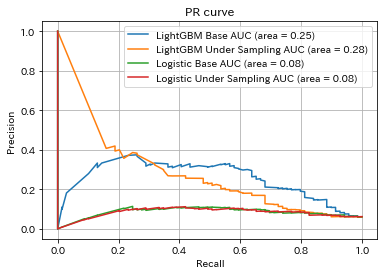

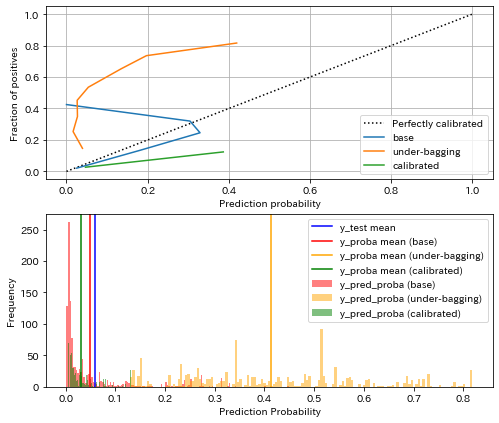

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


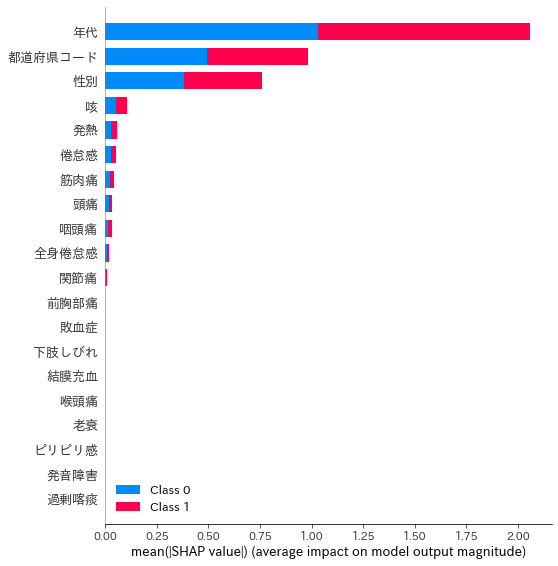

In [231]:
class UnderBaggingKFold(BaseCrossValidator):
    '''CV に使うだけで UnderBagging できるKFold実装(少ないクラスのデータは各 Fold で重複して選択される)'''

    def __init__(self, n_splits=5, shuffle=True, random_states=None, test_size=0.2, whole_testing=False):
        '''
        :param n_splits: Fold の分割数
        :param shuffle: 分割時にデータをシャッフルするか
        :param random_states: 各 Fold の乱数シード
        :param test_size: Under-sampling された中でテスト用データとして使う割合
        :param whole_testing: Under-sampling で選ばれなかった全てのデータをテスト用データに追加するか
        '''
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_states = random_states
        self.test_size = test_size
        self.whole_testing = whole_testing

        self.sample_indices_ = []

        if random_states is not None:
            # 各 Fold の乱数シードが指定されているなら分割数をそれに合わせる
            self.n_splits = len(random_states)
        else:
            # 乱数シードが指定されていないときは分割数だけ None で埋めておく
            self.random_states = [None] * self.n_splits

        # 分割数だけ Under-sampling 用のインスタンスを作っておく
        self.samplers_ = [
            RandomUnderSampler(random_state=random_state)
            for random_state in self.random_states
        ]

    def split(self, X, y=None, groups=None):
        '''データを学習用とテスト用に分割する'''
        if X.ndim < 2:
            # RandomUnderSampler#fit_resample() は X が 1d-array だと文句を言う
            X = np.vstack(X)

        for i in range(self.n_splits):
            # データを Under-sampling して均衡データにする
            sampler = self.samplers_[i]
            _, y_sampled = sampler.fit_resample(X, y)
            # 選ばれたデータのインデックスを取り出す
            sampled_indices = sampler.sample_indices_

            # 選ばれたデータのインデックスを記録しておく
            self.sample_indices_ = sampled_indices

            # 選ばれたデータを学習用とテスト用に分割する
            split_data = train_test_split(sampled_indices, shuffle=self.shuffle, test_size=self.test_size, stratify=y_sampled, random_state=self.random_states[i],)
            train_indices, test_indices = split_data

            if self.whole_testing:
                # Under-sampling で選ばれなかったデータをテスト用に追加する
                mask = np.ones(len(X), dtype=np.bool)
                mask[sampled_indices] = False
                X_indices = np.arange(len(X))
                non_sampled_indices = X_indices[mask]
                test_indices = np.concatenate([test_indices, non_sampled_indices])

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


class ModelExtractionCallback(object):
    # lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration

def calcurate_precision(test_data, data, percentage):
  p_1 = np.array(data)[test_data == 1]
  cal_percentage = 1 - percentage
  p_1_q = np.quantile(p_1,cal_percentage)
  y_q = test_data[np.array(data)>p_1_q]
  if sum(y_q) != 0:
    print('recallが', percentage, 'の割合で指定された時のprecision', sum(y_q)/len(y_q))

def main():
  df = df_new
  # df.columns = list(range(len(df.columns)))
  X = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  X = df.drop([""], axis=1).drop('ステータス', axis=1)
  y = df['ステータス']
  border_value = 0.2

  # 概要の出力
  print("重傷者の数の出力", df['ステータス'].value_counts())

  # 学習用データと検証用データに分割する (Hold-out)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # まずは不均衡データのまま学習させる
  lgb_params = {
      'bagging_fraction': 0.5656094985179433,
      'bagging_freq': 1,
      'feature_fraction': 0.4,
      'feature_pre_filter': False,
      'lambda_l1': 4.678162797519851e-06,
      'lambda_l2': 4.767625955074478,
      'metric': 'binary_logloss',
      'min_child_samples': 25,
      'num_leaves': 2,
      'objective': 'binary',
      'verbosity': -1
  }
  X_tr, X_ev, y_tr, y_ev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
  lgb_train = lgb.Dataset(X_tr, y_tr)
  lgb_eval = lgb.Dataset(X_ev, y_ev, reference=lgb_train)
  booster = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)

  # 検証用データを予測させる
  y_pred_proba_base = booster.predict(X_test)
  y_pred_base = np.where(y_pred_proba_base > border_value, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_base, percentage)

  # 均衡データで学習させる (UnderBagging)
  folds = UnderBaggingKFold(random_states=range(42, 42 + 5))
  lgb_train = lgb.Dataset(X_train, y_train)
  extraction_cb = ModelExtractionCallback()
  callbacks = [
      extraction_cb,
  ]
  lgb.cv(lgb_params, lgb_train,
          num_boost_round=1000,
          early_stopping_rounds=10,
          folds=folds,
          callbacks=callbacks,
          verbose_eval=10)
  cv_booster = extraction_cb.boosters_proxy
  # 検証用データを予測させる
  y_pred_proba_ub_list = cv_booster.predict(X_test)
  y_pred_proba_ub = np.array(y_pred_proba_ub_list).mean(axis=0)
  y_pred_ub = np.where(y_pred_proba_ub > border_value, 1, 0)

  # サンプリングレートを元に確率を補正する
  y_sampled = y_train.reindex(folds.sample_indices_)
  y_sampled_negative_len = np.count_nonzero(y_sampled == 0)
  beta = y_sampled_negative_len / len(y_train)
  y_pred_proba_cb = probability_calibration(y_pred_proba_ub, beta)
  y_pred_cb = np.where(y_pred_proba_cb > border_value, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_cb, percentage)

  # 各種評価指標を出力する
  print('precision (base): ', metrics.precision_score(y_test, y_pred_base))
  print('precision (under-bagging): ', metrics.precision_score(y_test, y_pred_ub))
  print('precision (calibrated): ', metrics.precision_score(y_test, y_pred_cb))
  print('recall (base): ', metrics.recall_score(y_test, y_pred_base))
  print('recall (under-bagging): ', metrics.recall_score(y_test, y_pred_ub))
  print('recall (calibrated): ', metrics.recall_score(y_test, y_pred_cb))
  print('F1 (base): ', metrics.f1_score(y_test, y_pred_base))
  print('F1 (under-bagging): ', metrics.f1_score(y_test, y_pred_ub))
  print('F1 (calibrated): ', metrics.f1_score(y_test, y_pred_cb))
  print('ROC AUC (base): ', metrics.roc_auc_score(y_test, y_pred_base))
  print('ROC AUC (under-bagging): ', metrics.roc_auc_score(y_test, y_pred_ub))
  print('ROC AUC (calibrated): ', metrics.roc_auc_score(y_test, y_pred_cb))

  # 各モデルが予測した内容の統計量
  print('y_test mean', y_test.mean())
  print('y_proba mean (base)', y_pred_proba_base.mean())
  print('y_proba mean (under-sampling)', y_pred_proba_ub.mean())
  print('y_proba mean (calibrated)', y_pred_proba_cb.mean())


  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train, y_train)
  # 検証用データを予測させる
  Y_pred_proba_base = clf.predict_proba(X_test)[:, 1]
  Y_pred_base = np.where(Y_pred_proba_base > border_value, 1, 0)

  # Under-sampling で均衡データにする
  sampler = RandomUnderSampler(random_state=42)
  X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

  # Over-sampling で均衡データにする
  over_sampler = SMOTE(random_state=42)
  X_train_over_sampled, y_train_over_sampled = over_sampler.fit_sample(X_train, y_train)

  # Under-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_sampled, y_train_sampled)
  # Under-samplingの検証用データを予測させる
  Y_pred_proba_us = clf.predict_proba(X_test)[:, 1]
  Y_pred_us = np.where(Y_pred_proba_us > border_value, 1, 0)

  # lightgbm base
  precision1, recall1, thresholds1 = metrics.precision_recall_curve(y_test, y_pred_proba_base)
  print("lightgbm base roc auc", metrics.roc_auc_score(y_test, y_pred_proba_base))
  auc1 = metrics.auc(recall1, precision1)

  # lightgbm undersampling
  precision2, recall2, thresholds2 = metrics.precision_recall_curve(y_test, y_pred_proba_ub)
  print("lightgbm us roc auc", metrics.roc_auc_score(y_test, y_pred_proba_ub))
  auc2 = metrics.auc(recall2, precision2)

  # logistic base
  precision3, recall3, thresholds3 = metrics.precision_recall_curve(y_test, Y_pred_proba_base)
  print("logi base roc auc", metrics.roc_auc_score(y_test, Y_pred_proba_base))
  auc3 = metrics.auc(recall3, precision3)

  # logistic undersampling
  precision4, recall4, thresholds4 = metrics.precision_recall_curve(y_test, Y_pred_proba_us)
  print("logi us roc auc", metrics.roc_auc_score(y_test, Y_pred_proba_us))
  auc4 = metrics.auc(recall4, precision4)

  plt.plot(recall1, precision1, label='LightGBM Base AUC (area = %.2f)'%auc1)
  plt.plot(recall2, precision2, label='LightGBM Under Sampling AUC (area = %.2f)'%auc2)
  plt.plot(recall3, precision3, label='Logistic Base AUC (area = %.2f)'%auc3)
  plt.plot(recall4, precision4, label='Logistic Under Sampling AUC (area = %.2f)'%auc4)
  plt.legend()
  plt.title('PR curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.grid(True)
  plt.show()

  # キャリブレーションカーブを計算する
  base_curve = calibration_curve(y_test, y_pred_proba_base, n_bins=10)
  underbagging_curve = calibration_curve(y_test, y_pred_proba_ub, n_bins=10)
  calibrated_curve = calibration_curve(y_test, y_pred_proba_cb, n_bins=10)

  # プロットする
  fig, axes = plt.subplots(2, 1, figsize=(8, 7))

  ax1 = axes[0]
  ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
  ax1.plot(base_curve[0], base_curve[1], label='base')
  ax1.plot(underbagging_curve[0], underbagging_curve[1], label='under-bagging')
  ax1.plot(calibrated_curve[0], calibrated_curve[1], label='calibrated')

  ax1.grid()
  ax1.set_ylabel('Fraction of positives')
  ax1.set_xlabel('Prediction probability')
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc='lower right')

  ax2 = axes[1]
  ax2.hist(y_pred_proba_base, bins=144, alpha=0.5, color='red', label='y_pred_proba (base)')
  ax2.hist(y_pred_proba_ub, bins=144, alpha=0.5, color='orange', label='y_pred_proba (under-bagging)')
  ax2.hist(y_pred_proba_cb, bins=144, alpha=0.5, color='green', label='y_pred_proba (calibrated)')
  ax2.axvline(x=y_test.mean(), color='blue', label='y_test mean')
  ax2.axvline(x=y_pred_proba_base.mean(), color='red', label='y_proba mean (base)')
  ax2.axvline(x=y_pred_proba_ub.mean(), color='orange', label='y_proba mean (under-bagging)')
  ax2.axvline(x=y_pred_proba_cb.mean(), color='green', label='y_proba mean (calibrated)')

  ax2.set_xlabel('Prediction Probability')
  ax2.set_ylabel('Frequency')

  plt.legend()
  plt.show()

  #　plot sharp summary
  explainer = shap.TreeExplainer(booster)
  X_tr_shap_values = explainer.shap_values(X_tr)
  shap.summary_plot(X_tr_shap_values, X_tr, feature_names=X_tr.columns, plot_type='bar')

if __name__ == '__main__':
    main()

In [232]:
# def main():
#   # データセットを読み込む
#   df = df_new
#   X = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
#   X = df.drop([""], axis=1).drop('ステータス', axis=1)
#   y = df['ステータス']

#   # 学習用データと検証用データに分割する (Hold-out)
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#   # LightGBM のデータセット表現にする
#   lgb_train = lgb.Dataset(X, y)

#   # データセットの分割方法
#   folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#   # 最適化するときの条件
#   lgbm_params = {
#       'objective': 'binary',
#       'metric': 'binary_logloss',
#   }
#   # 基本的には cv() 関数のオプションがそのまま渡せる
#   tuner_cv = lgb.LightGBMTunerCV(
#       lgbm_params, lgb_train,
#       num_boost_round=1000,
#       early_stopping_rounds=100,
#       verbose_eval=20,
#       folds=folds,
#   )

#   # 最適なパラメータを探索する
#   tuner_cv.run()

#   # 最も良かったスコアとパラメータを書き出す
#   print(f'Best score: {tuner_cv.best_score}')
#   print('Best params:')
#   pprint(tuner_cv.best_params)

# if __name__ == '__main__':
#     main()

# 各地域に対してモデルの適用

## 全体(重傷者312人/全体5465人)

In [233]:
# 都道府県の項目は外す
# plot_xgboost_result(df_new)

In [234]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new)

## 東京のみ(重傷者4人/全体222人)

In [235]:
# df_new_tokyo = df_new[df_new["都道府県コード"] == 13]
# plot_xgboost_result(df_new_tokyo)

In [236]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_tokyo)

## 神奈川のみ(重傷者56人/全体806人)

In [237]:
# df_new_kanagawa = df_new[df_new["都道府県コード"] == 14]
# plot_xgboost_result(df_new_kanagawa)

In [238]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kanagawa)

## 北海道のみ(重傷者34人/全体924人)

In [239]:
# df_new_hokkaido = df_new[df_new["都道府県コード"] == 1]
# plot_xgboost_result(df_new_hokkaido)

In [240]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_hokkaido)

## 近畿地方(重傷者169人/全体1878人)

In [241]:
# df_new_kinki = df_new[(df_new["都道府県コード"] == 24) | (df_new["都道府県コード"] == 25) | (df_new["都道府県コード"] == 26) | (df_new["都道府県コード"] == 27) | (df_new["都道府県コード"] == 28) | (df_new["都道府県コード"] == 29) | (df_new["都道府県コード"] == 30)]
# plot_xgboost_result(df_new_kinki)

In [242]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kinki)

## 関東地方(重傷者72人/全体1552人)

In [243]:
# df_new_kanto = df_new[(df_new["都道府県コード"] == 8) | (df_new["都道府県コード"] == 9) | (df_new["都道府県コード"] == 10) | (df_new["都道府県コード"] == 11) | (df_new["都道府県コード"] == 12) | (df_new["都道府県コード"] == 13) | (df_new["都道府県コード"] == 14)]
# plot_xgboost_result(df_new_kanto)

In [244]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kanto)

## 中部地方(重傷者33人/全体651人)

In [245]:
# df_new_chubu = df_new[(df_new["都道府県コード"] == 15) | (df_new["都道府県コード"] == 16) | (df_new["都道府県コード"] == 17) | (df_new["都道府県コード"] == 18) | (df_new["都道府県コード"] == 19) | (df_new["都道府県コード"] == 20) | (df_new["都道府県コード"] == 21) | (df_new["都道府県コード"] == 22) | (df_new["都道府県コード"] == 23)]
# plot_xgboost_result(df_new_chubu)

In [246]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_chubu)

## その他

九州地方、四国地方、東北地方、中国地方に関してはデータが不十分なので今回は分析を行わない。
```
# df_new_kyushu = df_new[(df_new["都道府県コード"] == 40) | (df_new["都道府県コード"] == 41) | (df_new["都道府県コード"] == 42) | (df_new["都道府県コード"] == 43) | (df_new["都道府県コード"] == 44) | (df_new["都道府県コード"] == 45) | (df_new["都道府県コード"] == 46) | (df_new["都道府県コード"] == 47)]
# plot_xgboost_result(df_new_kyushu)
```
```
# df_new_shikoku = df_new[(df_new["都道府県コード"] == 36) | (df_new["都道府県コード"] == 37) | (df_new["都道府県コード"] == 38) | (df_new["都道府県コード"] == 39)]
# plot_xgboost_result(df_new_shikoku)
```
```
# df_new_tohoku = df_new[(df_new["都道府県コード"] == 2) | (df_new["都道府県コード"] == 3) | (df_new["都道府県コード"] == 4) | (df_new["都道府県コード"] == 5) | (df_new["都道府県コード"] == 6) | (df_new["都道府県コード"] == 7)]
# plot_xgboost_result(df_new_tohoku)
```
```
# df_new_chugoku = df_new[(df_new["都道府県コード"] == 31) | (df_new["都道府県コード"] == 32) | (df_new["都道府県コード"] == 33) | (df_new["都道府県コード"] == 34) | (df_new["都道府県コード"] == 35)]
# plot_xgboost_result(df_new_chugoku)
```